In [1]:
import os
import subprocess

import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import rioxarray as rio
import rpy2.rinterface
import verde as vd
import xarray as xr

%load_ext rpy2.ipython

plt.style.use("ggplot")

In [2]:
eng = nivapy.da.connect_postgis()

Connection successful.


# Updating critical loads for water

## Part C: Making predictions

## 1. Setup prediction grid

The code below defines a regular, square grid across the whole of Norway that can be used for prediction.

In [3]:
# Setup output grid
# Bounding box for Norway in ETRS89-based UTM zone 33N
west, east, south, north = -90000, 1140000, 6430000, 7955000
extent = (west, east, south, north)

# Output resolution in m
spacing = 1000

# Build grid
xx, yy = vd.grid_coordinates(region=extent, spacing=spacing, pixel_register=True)

# Flatten to dataframe
grid_df = pd.DataFrame({"utm_east": xx.flatten(), "utm_north": yy.flatten()})
grid_df['pt_id'] = grid_df.index
grid_df.head()

,utm_east,utm_north,pt_id
0,-89500.0,6430500.0,0
1,-88500.0,6430500.0,1
2,-87500.0,6430500.0,2
3,-86500.0,6430500.0,3
4,-85500.0,6430500.0,4


## 2. Estimate co-variates for prediction grid

For each point in the prediction grid, the code below extracts values for runoff and elevation.

In [4]:
ro_grid_path = r"/home/jovyan/shared/teotil3/nve_hbv_data/runoff_1991-2020_mm_year.tif"
elev_grid_path = r"/home/jovyan/shared/01_datasets/spatial/dtm_merged_utm33/dtm_40m/norway_kartverket_40m_dtm_utm_z33.tif"

# Build indexers of cell co-ords
x_indexer = xr.DataArray(
    grid_df["utm_east"], dims=["pt_id"], coords=[grid_df["pt_id"]]
)
y_indexer = xr.DataArray(
    grid_df["utm_north"], dims=["pt_id"], coords=[grid_df["pt_id"]]
)

path_dict = {"runoff_mmpyr": ro_grid_path, "elevation_m": elev_grid_path}
for par, grid_path in path_dict.items():
    with rio.open_rasterio(grid_path, mask_and_scale=True) as ds:
        if par == "runoff_mmpyr":
            # Use the nearest cell in the runoff grid with data.
            ds = ds.rio.interpolate_na(method="nearest")
        else:
            # Assume points with no data or values less than 0 are at sea level
            ds = ds.where(ds > 0)
            ds = ds.fillna(0)

        # Get values for points
        pt_ds = ds.sel(x=x_indexer, y=y_indexer, method="nearest")
        pt_df = pt_ds.to_dataframe(name=par).reset_index()

        # Join
        grid_df = pd.merge(grid_df, pt_df[["pt_id", par]], how="left", on="pt_id")
        grid_df[par] = grid_df[par].round(0).astype(int)

grid_df.describe()

,utm_east,utm_north,pt_id,runoff_mmpyr,elevation_m
count,1.875750e+06,1.875750e+06,1.875750e+06,1.875750e+06,1.875750e+06
mean,5.250000e+05,7.192500e+06,9.378745e+05,1.016154e+03,1.175195e+02
std,3.550704e+05,4.402296e+05,5.414825e+05,5.741179e+02,2.862680e+02
min,-8.950000e+04,6.430500e+06,0.000000e+00,3.200000e+01,0.000000e+00
25%,2.175000e+05,6.811500e+06,4.689372e+05,5.130000e+02,0.000000e+00
50%,5.250000e+05,7.192500e+06,9.378745e+05,9.360000e+02,0.000000e+00
75%,8.325000e+05,7.573500e+06,1.406812e+06,1.382000e+03,0.000000e+00
max,1.139500e+06,7.954500e+06,1.875749e+06,7.092000e+03,2.308000e+03


## 3. Make predictions

The code in this section uses the statistical models from notebook 02b to predict values for each cell centre for each year. The standard error for each prediction is also stored. 

Predictions are made using `mgcv` in R and results are then put together in Python and converted into a georeferenced `xarray` dataset (i.e. a netCDF). The R script takes a single argument - the parameter name (either `TOC_mgpl` or `NO3_NO2_ugpl`), which defines the model to fit.

In [5]:
# Get approx. boundary of Norway. Useful for clipping the predictions, as the splines
# can go a bit wild for locations far away from data points. Use the vassdragsområder,
# as these extend offshore a bit, so we don't have to worry about coastline details
vassom_gdf = nivapy.da.read_postgis("physical", "norway_nve_vassdragomrade_poly", eng)
vassom_gdf = vassom_gdf.dissolve()

### 2.1. TOC

In [6]:
pars = ["TOC_mgpl"]
years = [2019]
nc_path = r"/home/jovyan/shared/critical_loads/norway_interpolated_toc_2019.nc"

ds_list = []
for par in pars:
    print("Processing", par)
    pred_list = []
    for year in years:
        print("  ", year)

        # Build df of prediction points for year
        grid_df_yr = grid_df.copy()
        grid_df_yr["year"] = year
        grid_df_yr.to_csv("grid_df_yr.csv", index=False)

        # Predict with R
        cmd = [
            "Rscript",
            "--vanilla",
            "02c_predict_mgcv.R",
            par,
        ]
        subprocess.check_call(cmd)

        # Read predictions and reshape
        pred_df = pd.read_csv("preds.csv")
        pred_list.append(pred_df["predicted"].values.reshape(xx.shape))

    # Stack data for all years into DataArray
    data = np.dstack(pred_list)
    da = xr.DataArray(data, coords=[yy[:, 0], xx[0], years], dims=["y", "x", "year"])

    # Convert to Dataset
    ds = da.to_dataset(name=par)
    ds_list.append(ds)

os.remove("grid_df_yr.csv")
os.remove("preds.csv")

# Merge datasets
ds = xr.merge(ds_list)

# Add geospatial info
ds = ds.rio.write_crs("epsg:25833")
ds = ds.rio.write_transform()

# Set negative values to 0
ds = ds.where(ds > 0, 0)

# Clip to vassdragsområder
ds = ds.rio.clip(vassom_gdf.geometry.values, vassom_gdf.crs, drop=True, invert=False)

# Set NoData value and convert to 32-Bit
for par, _ in ds.items():
    ds[par].rio.write_nodata(-9999, encoded=True, inplace=True)
    ds[par] = ds[par].astype("float32")

ds.to_netcdf(nc_path)

ds

Processing TOC_mgpl
   2019


<xarray.Dataset>
Dimensions:      (y: 1496, x: 1198, year: 1)
Coordinates:
  * y            (y) float64 6.446e+06 6.448e+06 ... 7.94e+06 7.942e+06
  * x            (x) float64 -7.95e+04 -7.85e+04 ... 1.116e+06 1.118e+06
  * year         (year) int64 2019
    spatial_ref  int64 0
Data variables:
    TOC_mgpl     (y, x, year) float32 nan nan nan nan nan ... nan nan nan nan

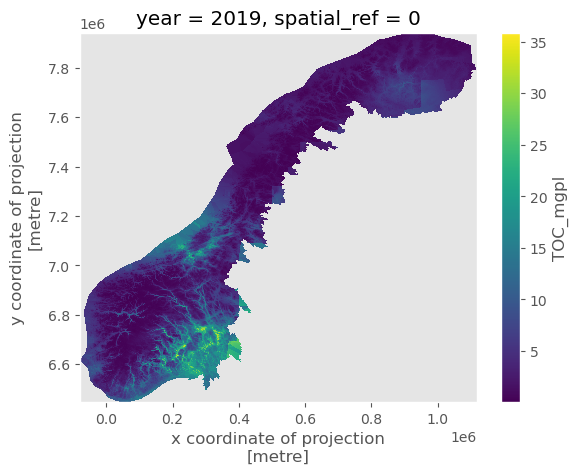

In [7]:
ds['TOC_mgpl'].sel(year=2019).plot()

### 2.2. NO3

**Note:** Predicting on a 1 km by 1 km grid is slow - **the code below will take several hours to run**.

In [8]:
pars = ["NO3_NO2_ugpl"]
years = range(1990, 2021 + 1)
nc_path = r"/home/jovyan/shared/critical_loads/norway_interpolated_no3_1990-2021.nc"

ds_list = []
for par in pars:
    print("Processing", par)
    pred_list = []
    for year in years:
        print("  ", year)

        # Build df of prediction points for year
        grid_df_yr = grid_df.copy()
        grid_df_yr["year"] = year
        grid_df_yr.to_csv("grid_df_yr.csv", index=False)

        # Predict with R
        cmd = [
            "Rscript",
            "--vanilla",
            "02c_predict_mgcv.R",
            par,
        ]
        subprocess.check_call(cmd)

        # Read predictions and reshape
        pred_df = pd.read_csv("preds.csv")
        pred_list.append(pred_df["predicted"].values.reshape(xx.shape))

    # Stack data for all years into DataArray
    data = np.dstack(pred_list)
    da = xr.DataArray(data, coords=[yy[:, 0], xx[0], years], dims=["y", "x", "year"])

    # Convert to Dataset
    ds = da.to_dataset(name=par)
    ds_list.append(ds)

os.remove("grid_df_yr.csv")
os.remove("preds.csv")

# Merge datasets
ds = xr.merge(ds_list)

# Add geospatial info
ds = ds.rio.write_crs("epsg:25833")
ds = ds.rio.write_transform()

# Set negative values to 0
ds = ds.where(ds > 0, 0)

# Clip to vassdragsområder
ds = ds.rio.clip(vassom_gdf.geometry.values, vassom_gdf.crs, drop=True, invert=False)

# Set NoData value and convert to 32-Bit
for par, _ in ds.items():
    ds[par].rio.write_nodata(-9999, encoded=True, inplace=True)
    ds[par] = ds[par].astype("float32")

ds.to_netcdf(nc_path)

ds

Processing NO3_NO2_ugpl
   1990
   1991
   1992
   1993
   1994
   1995
   1996
   1997
   1998
   1999
   2000
   2001
   2002
   2003
   2004
   2005
   2006
   2007
   2008
   2009
   2010
   2011
   2012
   2013
   2014
   2015
   2016
   2017
   2018
   2019
   2020
   2021


<xarray.Dataset>
Dimensions:       (y: 1496, x: 1198, year: 32)
Coordinates:
  * y             (y) float64 6.446e+06 6.448e+06 ... 7.94e+06 7.942e+06
  * x             (x) float64 -7.95e+04 -7.85e+04 ... 1.116e+06 1.118e+06
  * year          (year) int64 1990 1991 1992 1993 1994 ... 2018 2019 2020 2021
    spatial_ref   int64 0
Data variables:
    NO3_NO2_ugpl  (y, x, year) float32 nan nan nan nan nan ... nan nan nan nan

In [9]:
# ds['NO3_NO2_ugpl'].sel(year=2019).plot(vmax=120)

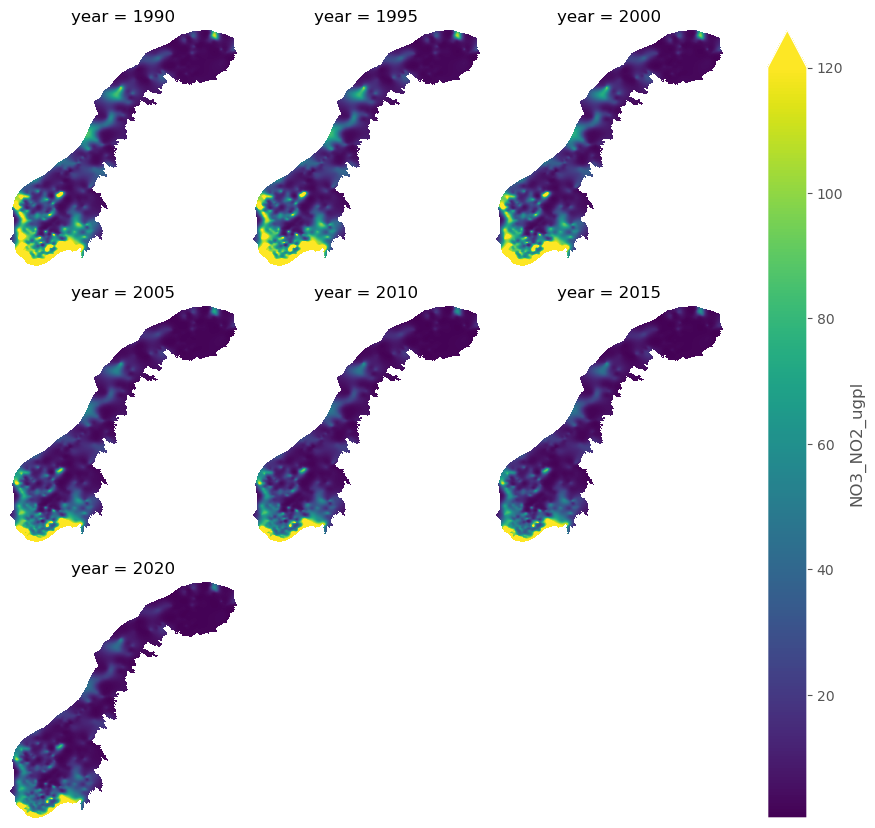

In [10]:
# Maps every 5 years for NO3
axes = (
    ds["NO3_NO2_ugpl"]
    .sel(year=[1990, 1995, 2000, 2005, 2010, 2015, 2020])
    .plot(col="year", vmax=120, col_wrap=3)
)
for ax in axes.axes.flatten():
    ax.axis("off")